In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [23]:
data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0)
data.sample(3)

,META_TEMPORAL_VOLUME,INFERIOR_CEREBGM_VOLUME,HEMIWM_VOLUME,BRAIN_STEM_VOLUME,CHOROID_VOLUME,MIDDLEFR_VOLUME,ORBITOFR_VOLUME,PARSFR_VOLUME,CTX_BANKSSTS_VOLUME,CTX_CAUDALANTERIORCINGULATE_VOLUME,...,CTX_SUPERIORTEMPORAL_VOLUME,CTX_SUPRAMARGINAL_VOLUME,CTX_TEMPORALPOLE_VOLUME,CTX_TRANSVERSETEMPORAL_VOLUME,ACCUMBENS_AREA_VOLUME,AMYGDALA_VOLUME,CAUDATE_VOLUME,PALLIDUM_VOLUME,PUTAMEN_VOLUME,THALAMUS_PROPER_VOLUME
42,66577.0,68910.0,414771.0,22941.0,1272.0,38269.0,27946.0,17019.0,4062.0,3381.0,...,22651.0,22857.0,5705.0,1786.0,902.0,2777.0,6955.0,3637.0,9372.0,13924.0
448,76132.0,72122.0,451776.0,23191.0,1424.0,43461.0,28672.0,22161.0,4675.0,4346.0,...,24794.0,22739.0,5300.0,2507.0,849.0,3829.0,8099.0,3518.0,9582.0,15311.0
217,62235.0,64922.0,358005.0,20558.0,1488.0,39336.0,26489.0,18057.0,3313.0,4639.0,...,19808.0,15994.0,5282.0,2228.0,956.0,2993.0,6674.0,3572.0,8026.0,11637.0


In [24]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

In [25]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd',
                       assume_centered=True)

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

In [106]:
alphas = np.linspace(0.05,1.,128)
precision_nonzero = []
covariance_nonzero = []
log_likelihoods = []

n_features = len(data_scaled.columns)
n_samples = len(data_scaled)

for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-3, mode='cd', eps=1e-6, assume_centered=True)
    model.fit(data_scaled)

    log_likelihoods.append(model.score(data_scaled))
    precision_nonzero.append(np.count_nonzero(model.precision_))
    covariance_nonzero.append(np.count_nonzero(model.covariance_))

log_likelihoods = np.array(log_likelihoods)
precision_nonzero = np.array(precision_nonzero)
covariance_nonzero = np.array(covariance_nonzero)

  3%|▎         | 4/128 [00:00<00:06, 19.20it/s]/home/ksrnk/opt/mambaforge/envs/brain-graph/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -4.768e-03
  warnings.warn(
  8%|▊         | 10/128 [00:03<00:38,  3.10it/s]/home/ksrnk/opt/mambaforge/envs/brain-graph/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.434e-03
  warnings.warn(
  9%|▉         | 12/128 [00:06<01:16,  1.52it/s]/home/ksrnk/opt/mambaforge/envs/brain-graph/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.090e-03
  warnings.warn(
100%|██████████| 128/128 [00:11<00:00, 11.18it/s]


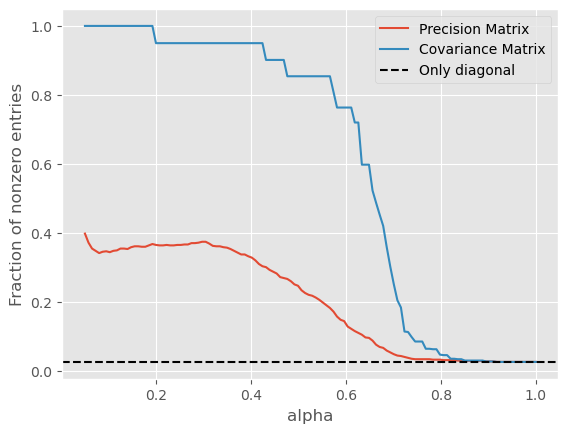

In [107]:
plt.plot(alphas,precision_nonzero/n_features**2,label="Precision Matrix")
plt.plot(alphas,covariance_nonzero/n_features**2,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.legend();

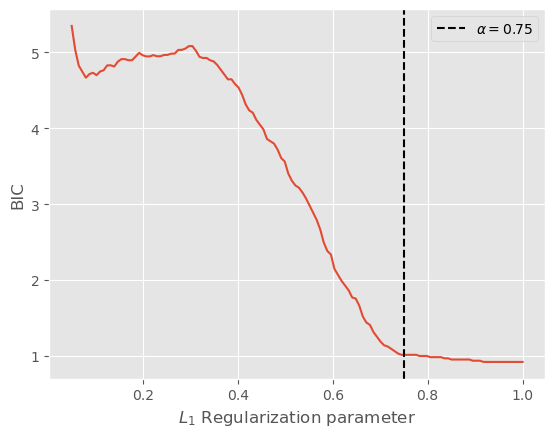

In [129]:
bics = (- 2 * log_likelihoods + ((precision_nonzero - n_features)/2 + n_features) * np.log(n_samples))/n_samples

plt.plot(alphas,bics)
plt.ylabel("BIC")
alpha = 0.75
plt.axvline(alpha,color='k',linestyle='--',label=r"$\alpha="+str(alpha)+"$")
plt.xlabel(r"$L_1$ Regularization parameter")
plt.legend();


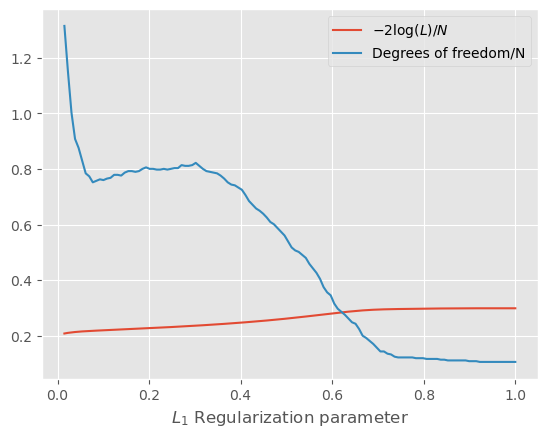

In [104]:
plt.plot(alphas,-2*log_likelihoods/n_samples,label=r'$-2 \log(L)/N$')
plt.plot(alphas,((precision_nonzero - n_features)/2 + n_features)/n_samples,label='Degrees of freedom/N')
plt.legend()
# plt.plot(alphas,bics)
plt.xlabel(r"$L_1$ Regularization parameter");

# Make graphs